In [1]:
#!pip uninstall --yes scikit-learn
#!pip install scikit-learn==0.24.2

import math
import numpy as np
import pandas as pd
import sklearn
from numpy import array
import keras.losses
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras import initializers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
#from keras.optimizers import Adam
#from keras.optimizers import SGD
#from keras.optimizers.schedules import ExponentialDecay
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import feather

#check sklearn version
#print('The scikit-learn version is {}.'.format(sklearn.__version__))
#tscv = TimeSeriesSplit()

# univariate data preparation
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)



# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X,y = list(),list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix,:-1], sequences[end_ix,2] # x columns are inputs and y comlumns are targets
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


# choose a number of time steps (lookback)
n_steps = 3 #ta warosc powinna chyba byc odczytywana na podstawie acf/pacf
n_features = 2 #równe liczbie kolumn danych wejsciowych
rolling = 504

In [2]:
# load the new file
#norm
#garch_forecasts = feather.read_dataframe('../input/garch-forecasts/garch_forecasts.feather')
#std
#garch_forecasts = feather.read_dataframe('../input/garch-forecasts/garch_std_forecasts.feather')
#sstd
garch_forecasts = feather.read_dataframe('../EXPORTS/garch_forecasts_dt_wig.feather')
garch_forecasts

,Realized Ret,sGARCH_norm_mu,sGARCH_norm_sigma,sGARCH_norm_skew,sGARCH_norm_shape,sGARCH_std_mu,sGARCH_std_sigma,sGARCH_std_skew,sGARCH_std_shape,sGARCH_sstd_mu,...,apARCH_std_skew,apARCH_std_shape,apARCH_sstd_mu,apARCH_sstd_sigma,apARCH_sstd_skew,apARCH_sstd_shape,vYZ_252,vGKYZ,SvOLHC,vGKYZ_252
0,3.997220,-0.102988,1.587339,0.0,0.0,-0.105540,1.604870,0.0,9.079177,-0.103576,...,0.0,8.961740,-0.121788,1.207937,0.997677,7.659950,2.084086,1.800430,2.052456,2.858094
1,-1.452782,0.298854,1.888869,0.0,0.0,0.269523,1.924219,0.0,8.906844,0.277625,...,0.0,8.737286,0.345125,1.361034,1.019161,6.745703,3.863739,2.614449,2.980422,4.150309
2,1.030752,-0.187024,1.858411,0.0,0.0,-0.184709,1.893615,0.0,8.724265,-0.181783,...,0.0,8.716029,-0.185473,1.593030,1.041003,7.192888,3.928073,1.555927,1.773727,2.469957
3,-1.724302,0.031616,1.804535,0.0,0.0,0.016095,1.829890,0.0,8.801472,0.025897,...,0.0,8.835265,0.028521,1.526896,1.083098,7.243196,2.378009,1.486637,1.694739,2.359964
4,0.672312,-0.197939,1.784883,0.0,0.0,-0.200867,1.812935,0.0,8.609257,-0.194546,...,0.0,8.718504,-0.212118,1.660696,1.018347,8.236783,1.294471,1.250405,1.425438,1.984957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,1.775053,-0.044788,1.390757,0.0,0.0,0.035245,1.433851,0.0,4.053986,0.038465,...,0.0,4.613152,-0.035684,1.396742,0.926710,4.663212,3.308255,0.691247,0.788008,1.097320
4748,1.324246,0.036307,1.438278,0.0,0.0,-0.034541,1.475440,0.0,4.019707,-0.070096,...,0.0,4.641633,-0.071988,1.358195,0.923383,4.700529,0.811633,0.794429,0.905635,1.261118
4749,2.351989,0.034856,1.419019,0.0,0.0,-0.019248,1.470990,0.0,3.992674,-0.049900,...,0.0,4.652064,-0.061981,1.306403,0.921476,4.718038,0.829765,0.906034,1.032862,1.438284
4750,0.920912,0.060007,1.534098,0.0,0.0,-0.029887,1.592723,0.0,4.047991,-0.067262,...,0.0,4.656491,-0.063489,1.284572,0.925517,4.709906,0.748946,0.736434,0.839521,1.169053


In [ ]:
figs = plt.figure()
plt.figure(figsize=(20, 6), dpi=200)
plt.plot(garch_forecasts[['SvOLHC']][800:])
plt.plot(garch_forecasts[['GARCH_sstd_sigma']][800:])

#plt.plot(garch_forecasts[['Mu']][-568:].reset_index(drop=True))
#plt.plot(Xtest)
plt.title('model accuracy')
plt.ylabel('HV')
plt.xlabel('time')
plt.legend(['RV', 'GARCH'], loc='upper left')

In [ ]:
#test if index is not shifted - it's not, shiting it by -1 has almost 0 mse
garch_forecasts[['Realized Ret']] = np.roll(garch_forecasts[['Realized Ret']], shift=-1)
garch_forecasts[['Realized Ret']] 

In [4]:
# convert to [rows, columns] structure
in_seq1 = garch_forecasts[['Realized Ret']]  ###moze na wejsciu powinny być squared returns?
in_seq2 = abs(garch_forecasts[['Realized Ret']])
in_seq3 = garch_forecasts[['gjrGARCH_sstd_sigma']]#**2
in_seq4 = garch_forecasts[['vGKYZ_252']]
# horizontally stack columns
dataset = np.hstack(( in_seq2, in_seq3, in_seq4)) #dodajemy też seq4 czyli HV jako input

In [ ]:
#to jest źle
#walk forward validation/rolling window lopp
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
dt = np.array(range(1, 2334))

tscv = TimeSeriesSplit(n_splits=4, max_train_size=1008, test_size=504, gap=0)

for train_index, test_index in tscv.split(dt):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = dt[train_index], dt[test_index]


train length= 1008
test length= 507
training the model...
plotting loss...


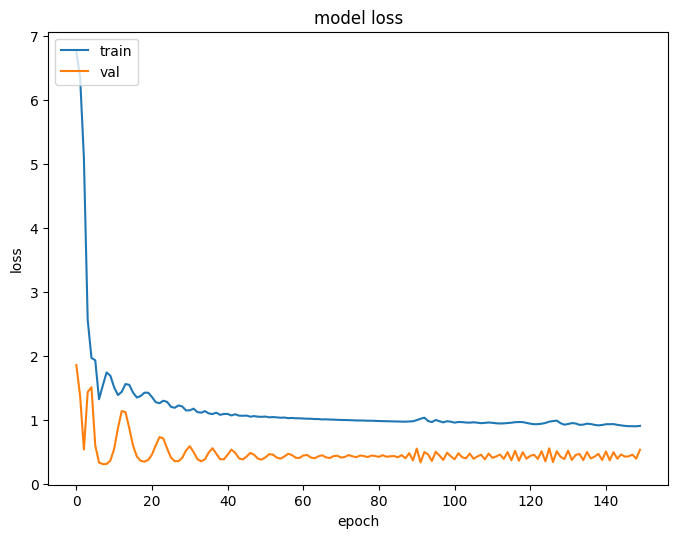

making predictions...
16/16 - 1s - 724ms/epoch - 45ms/step
eveluating the model...
16/16 [==============================] - 1s 4ms/step - loss: 0.7332
plotting predictions...


<Figure size 432x288 with 0 Axes>

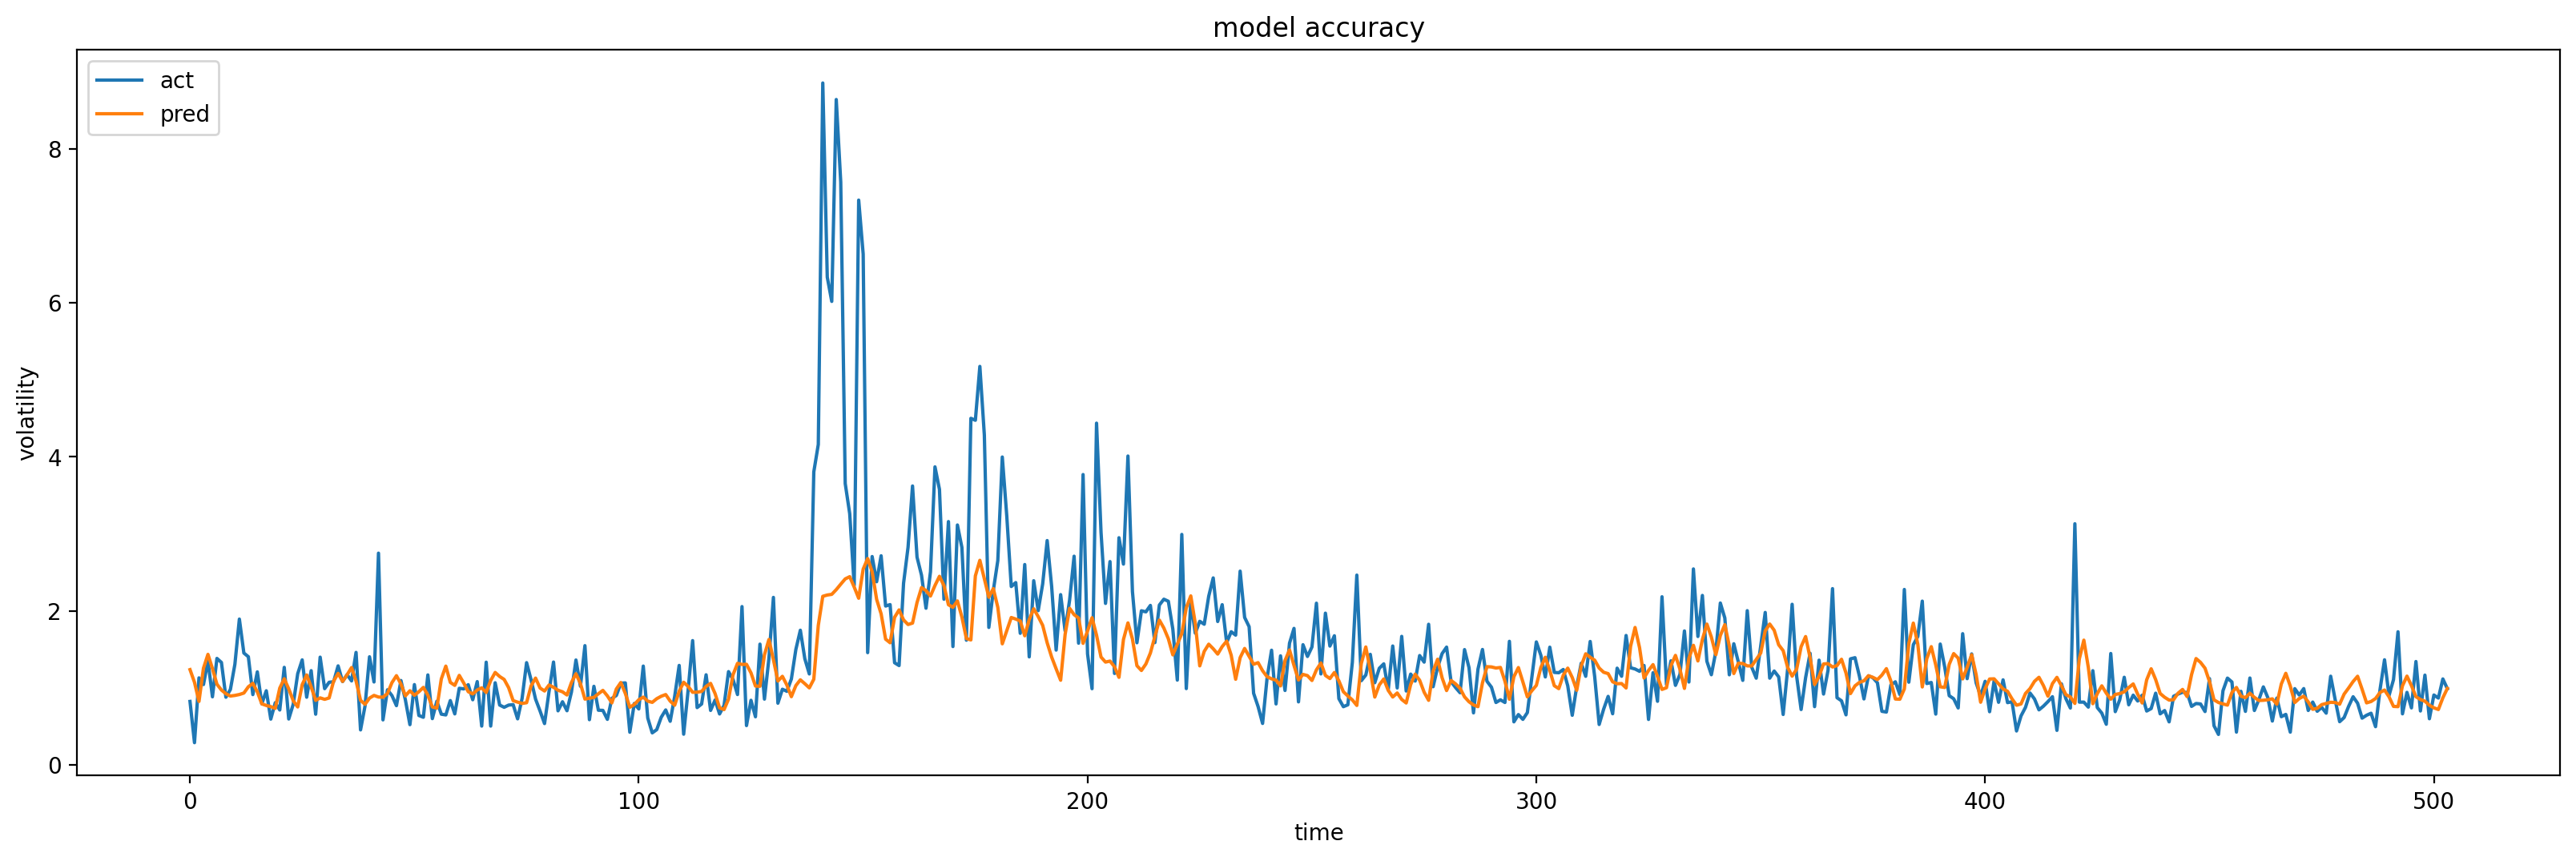

train length= 1512
test length= 507
training the model...
plotting loss...


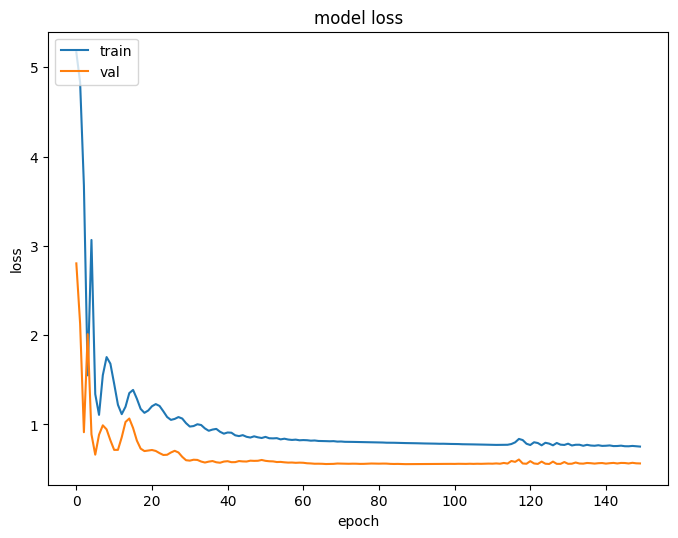

making predictions...
16/16 - 1s - 689ms/epoch - 43ms/step
eveluating the model...
16/16 [==============================] - 1s 4ms/step - loss: 0.3477
plotting predictions...


<Figure size 432x288 with 0 Axes>

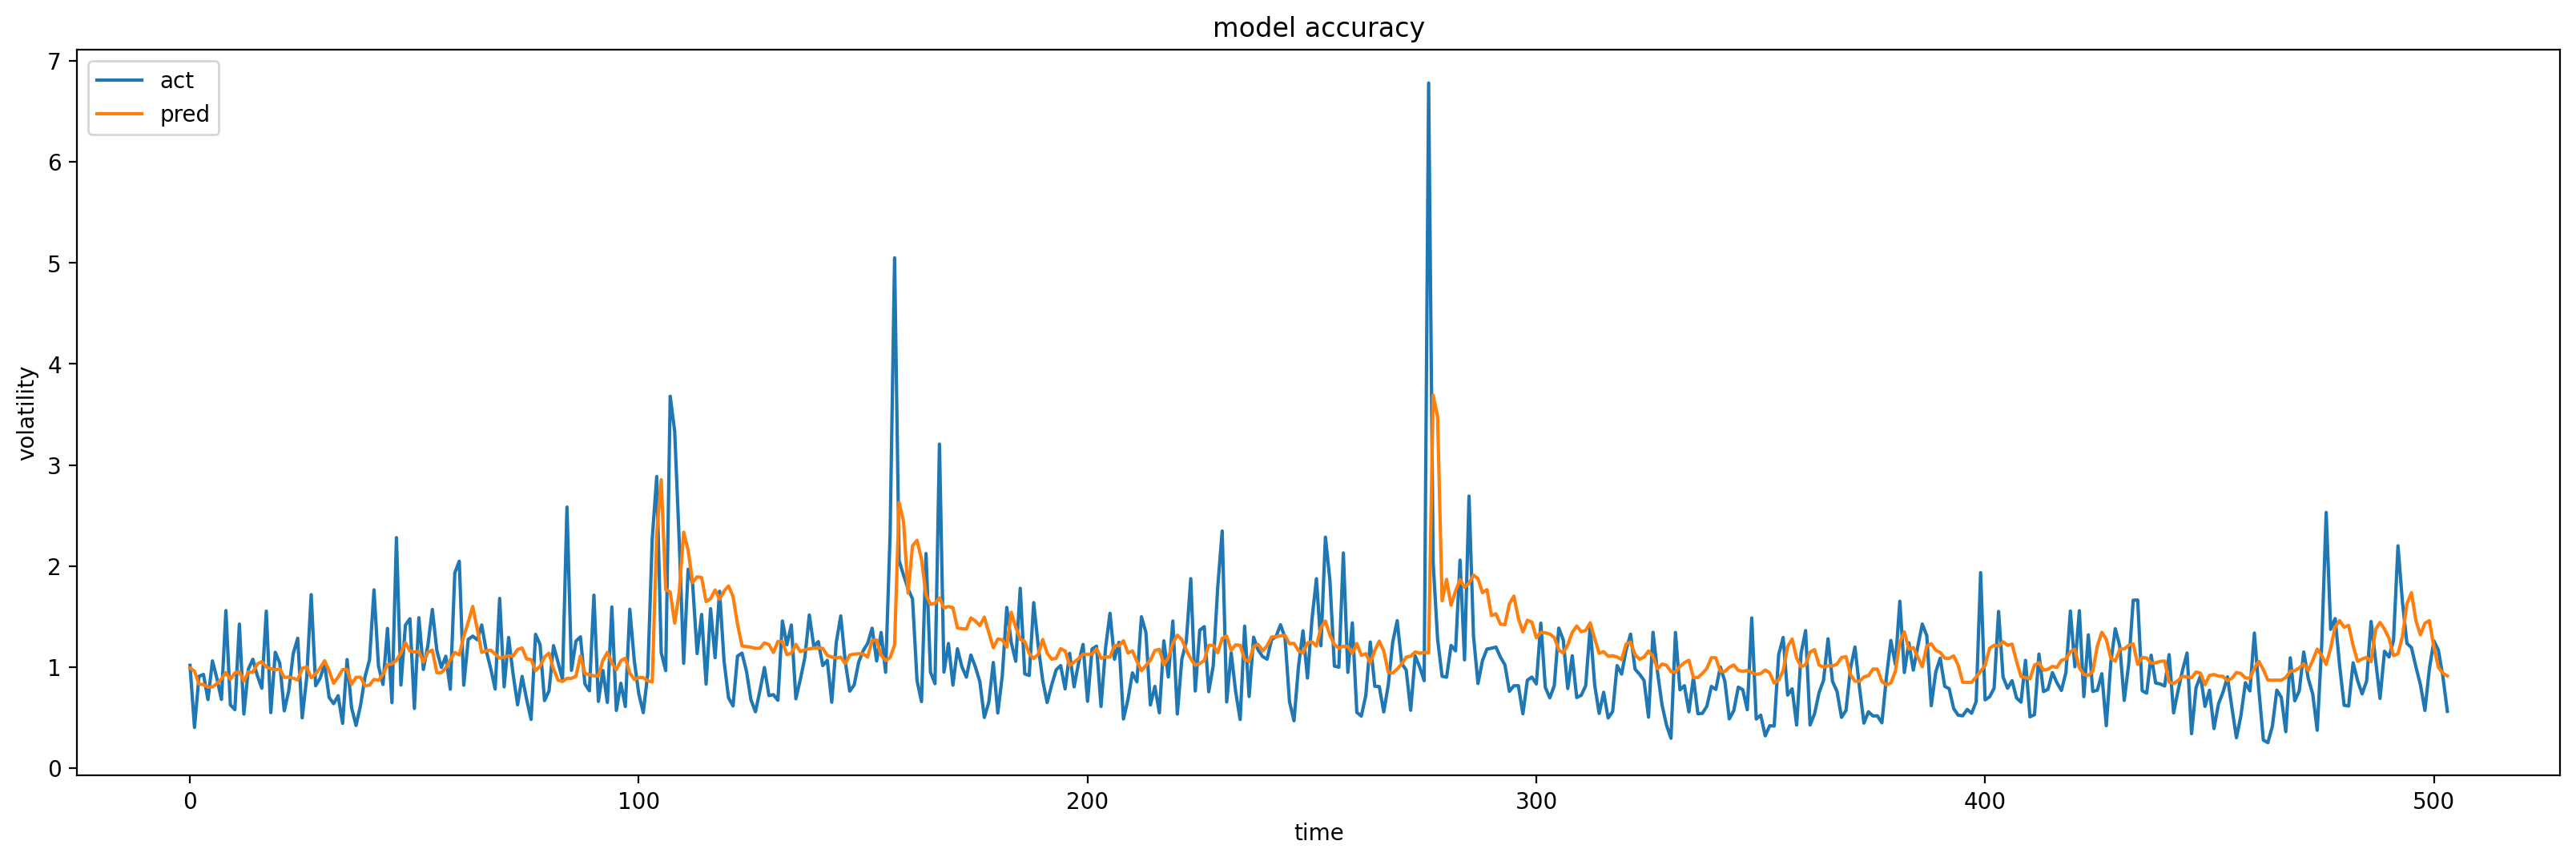

train length= 2016
test length= 507
training the model...
plotting loss...


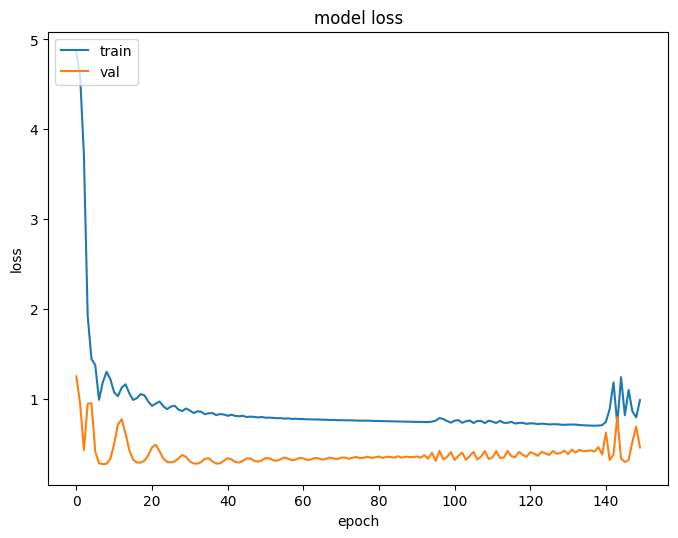

making predictions...
16/16 - 1s - 685ms/epoch - 43ms/step
eveluating the model...
16/16 [==============================] - 1s 4ms/step - loss: 0.6423
plotting predictions...


<Figure size 432x288 with 0 Axes>

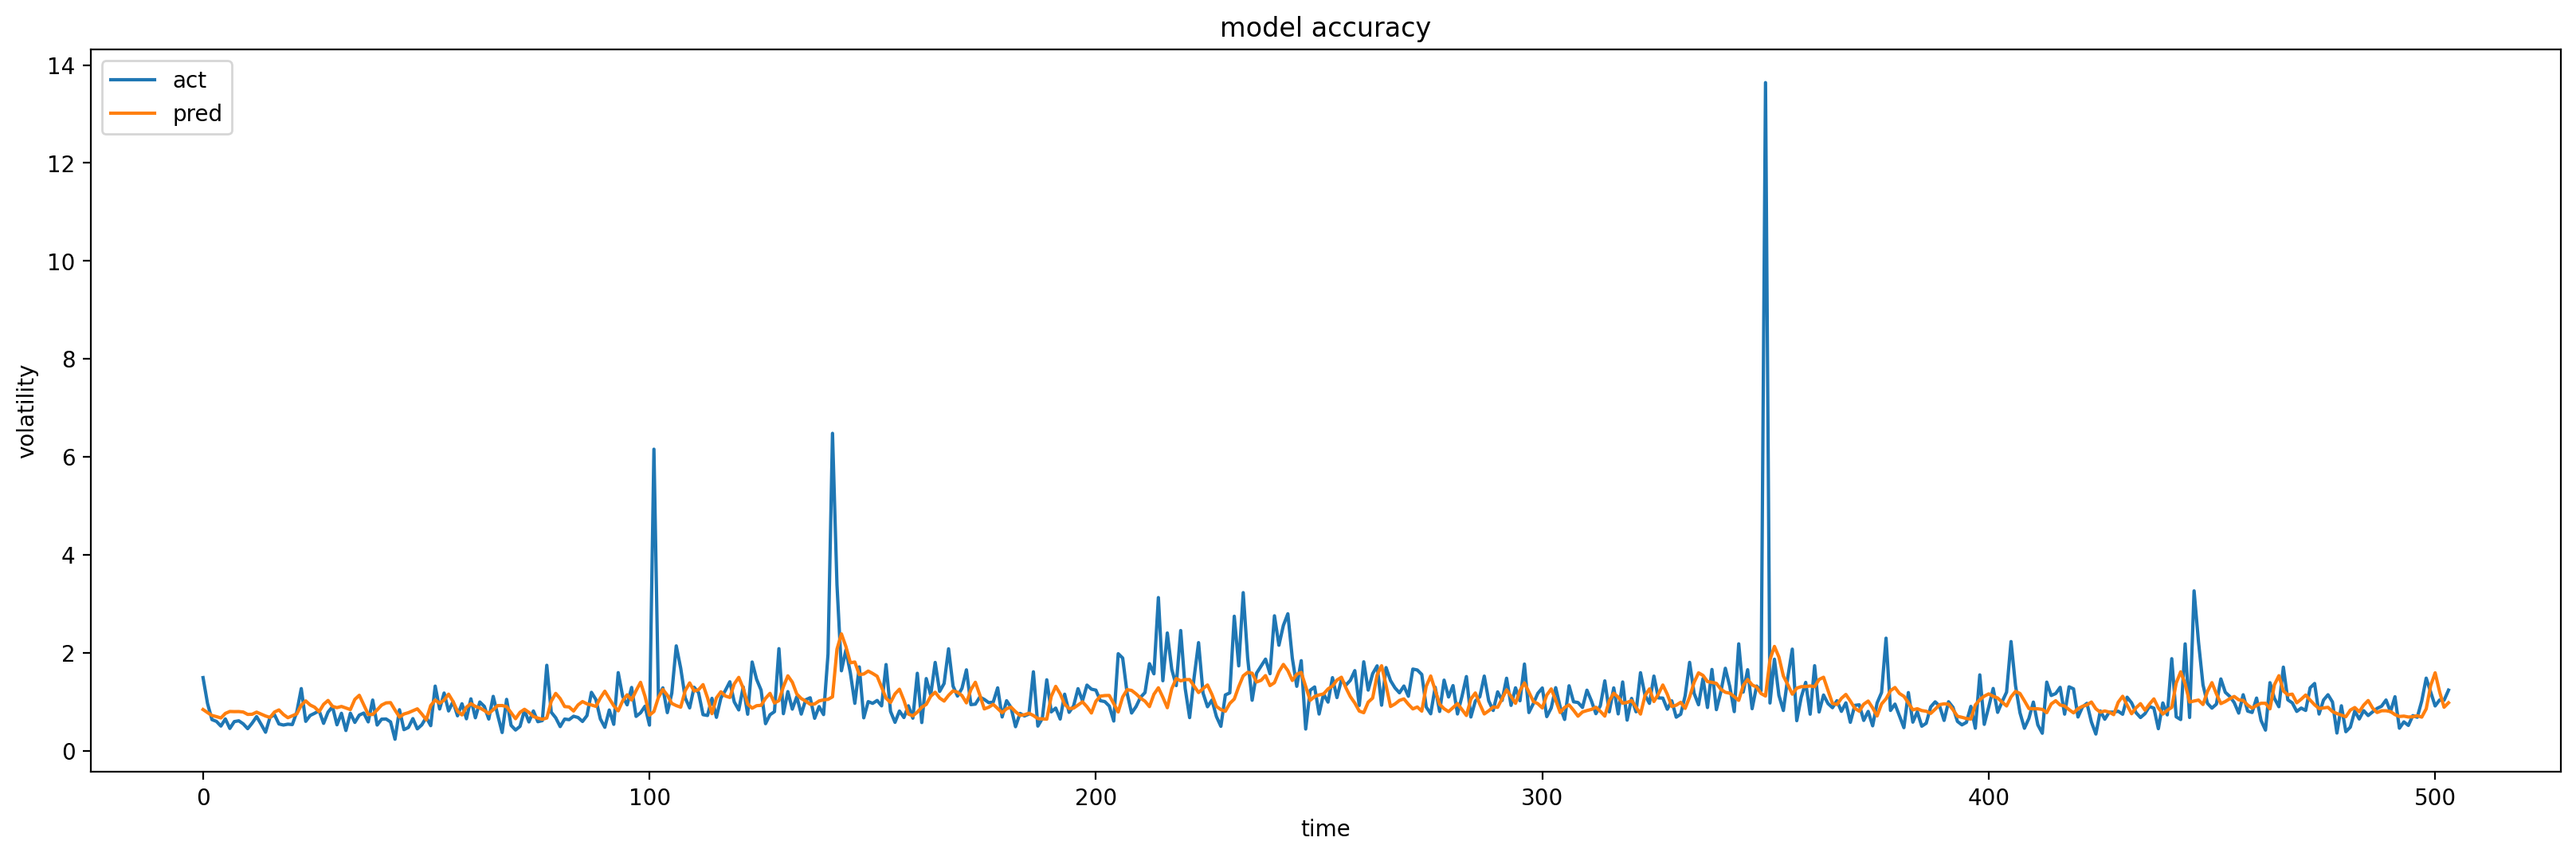

train length= 2520
test length= 507
training the model...
plotting loss...


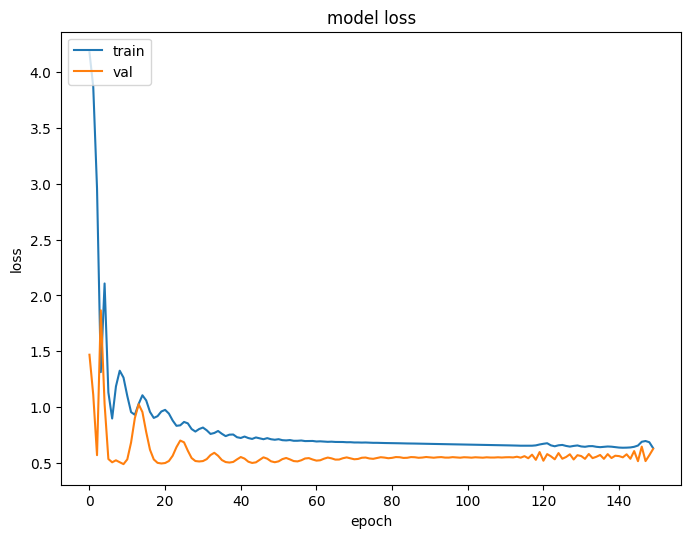

making predictions...
16/16 - 1s - 686ms/epoch - 43ms/step
eveluating the model...
16/16 [==============================] - 1s 4ms/step - loss: 0.2136
plotting predictions...


<Figure size 432x288 with 0 Axes>

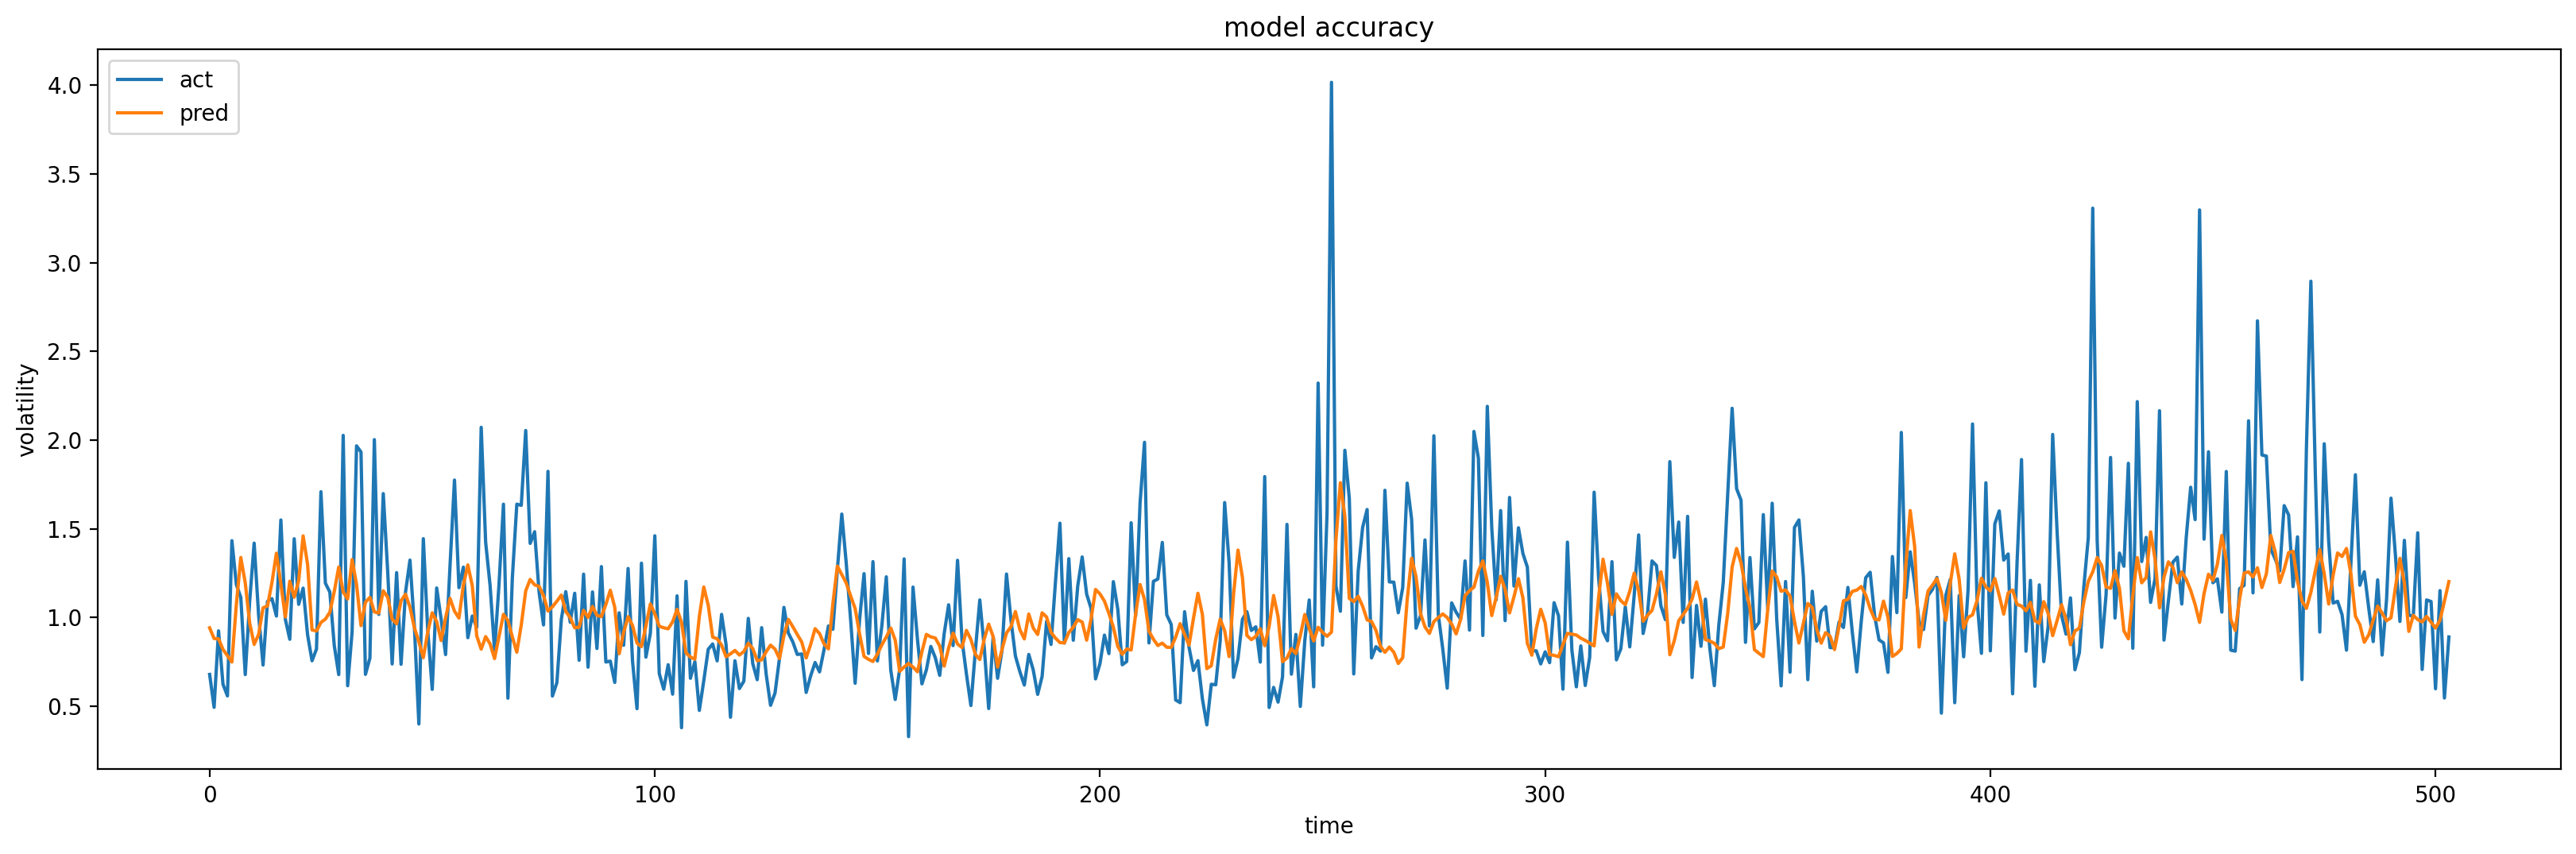

train length= 3024
test length= 474
training the model...
plotting loss...


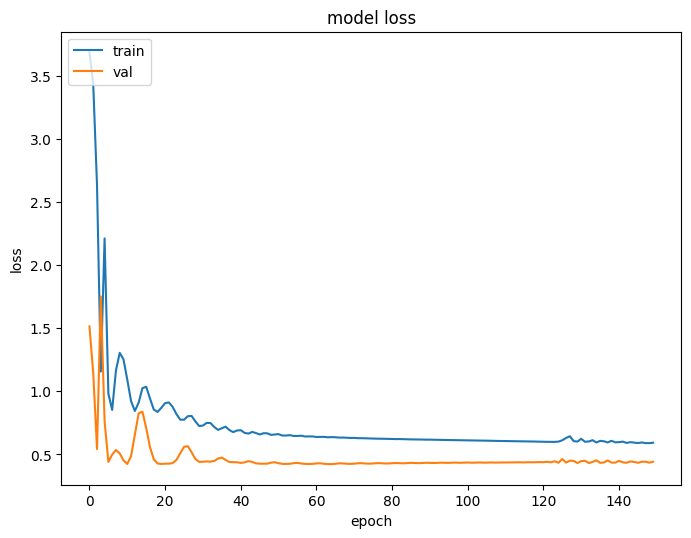

making predictions...
15/15 - 1s - 697ms/epoch - 46ms/step
eveluating the model...
15/15 [==============================] - 1s 4ms/step - loss: 0.5613
plotting predictions...


<Figure size 432x288 with 0 Axes>

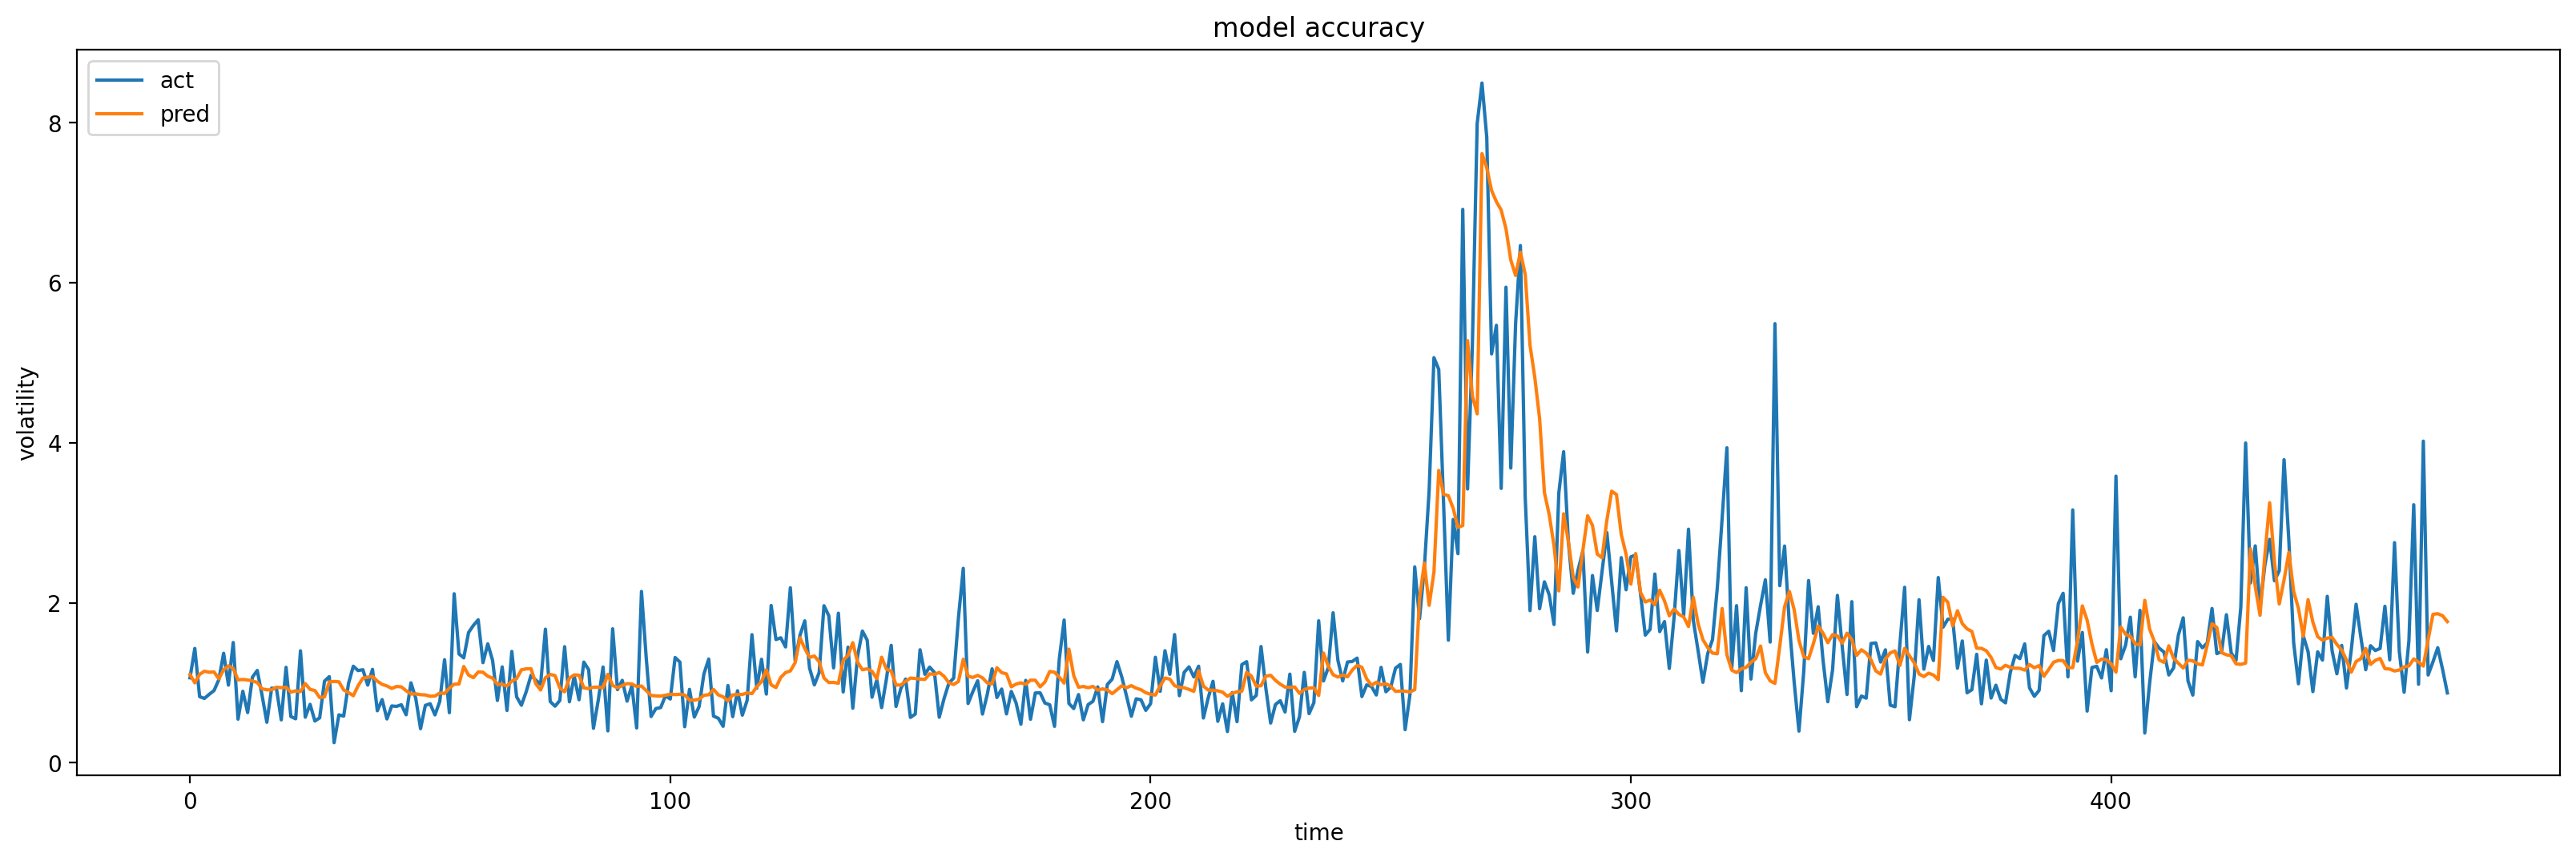

In [5]:
#initialize random weights
initializer = initializers.GlorotUniform(seed=0)

#train test split/rolling window

#https://stackoverflow.com/questions/58295242/sliding-window-train-test-split-for-time-series-data
data = dataset[-3495:] #last 3495 obs
train_size = 1008
window_size = 504 #test size
splits = []
yhat_total = []

for i in range(train_size, len(data), window_size):
    train = np.array(data[0:i])
    print("train length=", len(train))
    test = np.array(data[i-n_steps:i+window_size])
    print("test length=", len(test))
    #splits.append(('TRAIN:', train, 'TEST:', test))
    X,y = split_sequences(train, n_steps)
    #print(X[0],y[0])
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    #print(X)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0, restore_best_weights = True) # ten ostatni argument robi to samo co mc
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=0)
    
    
    # define model
    model = Sequential()

    # model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    # model.add(MaxPooling1D(pool_size=2))


    model.add(LSTM(128, activation="tanh", kernel_regularizer=regularizers.l2(0.00002), return_sequences=True, input_shape=(n_steps, n_features) ))
    model.add(Dropout(0.0002))

    model.add(LSTM(512,activation="tanh",  kernel_regularizer=regularizers.l2(0.00002), return_sequences=True))
    model.add(Dropout(0.0002))

    model.add(LSTM(128, kernel_regularizer=regularizers.l2(0.00002),  activation="tanh"))
    model.add(Dropout(0.0002))


    model.add(Dense(1))#activation linear jest chyba domyślnie

    opt = tf.keras.optimizers.Adam(learning_rate = 0.005)
    model.compile(optimizer=opt, loss = "mse", metrics="mae")
    
    
    # fit model
    print("training the model...")
    history = model.fit(X, y, batch_size = 3000, validation_split = 0.3333, epochs=150, verbose=0, callbacks = [mc])
    
    #plot loss
    print("plotting loss...")
    from matplotlib.pyplot import figure
    %matplotlib inline

    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig("file_name.png")
    plt.show()
    
    #load mc model
    saved_model = load_model('best_model.h5', compile=False)
    saved_model.compile(optimizer=opt, loss = "mse")
    
    #split test set
    Xtest, ytest = split_sequences(test, n_steps)
    Xtest = Xtest.reshape((Xtest.shape[0], Xtest.shape[1], n_features))
    
    #make predictions on test set
    print("making predictions...")
    yhat = saved_model.predict(Xtest, verbose=2)
    
    #evalueate test set
    print("eveluating the model...")
    ev = saved_model.evaluate(Xtest, ytest,verbose=1)
    
    #plot predictions
    print("plotting predictions...")
    
    figs = plt.figure()
    plt.figure(figsize=(20, 6), dpi=200)
    plt.plot(ytest)
    plt.plot(yhat)
    #plt.plot(garch_forecasts[['Mu']][-568:].reset_index(drop=True))
    #plt.plot(Xtest)
    plt.title('model accuracy')
    plt.ylabel('volatility')
    plt.xlabel('time')
    plt.legend(['act', 'pred'], loc='upper left')
    plt.show()
    
    yhat_r = np.reshape(yhat, (len(yhat)))
    
    yhat_total.extend(yhat_r.tolist())

# View result
#for a_tuple in splits:
#    print(a_tuple)
    

# ('TRAIN:', array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 'TEST:', array([12, 13, 14]))
# ('TRAIN:', array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), 'TEST:', array([13, 14, 15]))
# ('TRAIN:', array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 'TEST:', array([14, 15, 16]))

In [6]:
len(yhat_total)

2487

In [213]:
yhat_total.count('nan')

0

In [7]:
#NN MSE
mean_squared_error(garch_forecasts[['vGKYZ_252']][-len(yhat_total):],yhat_total)

0.4825385052445137

In [32]:
#GARCH MSE
mean_squared_error(garch_forecasts[['vGKYZ_252']][-len(yhat_total):],garch_forecasts[['gjrGARCH_norm_sigma']][-len(yhat_total):])

0.48019597075471826

In [139]:
#NN vs GARCH MSE
mean_squared_error(yhat_total,garch_forecasts[['sGARCH_norm_sigma']][-len(yhat_total):])

0.1469076976705438

In [ ]:
garch_forecasts[['SvOLHC']][-len(yhat_total):].values.tolist()

In [ ]:
#hmse
from statistics import mean
#mean((1-pd.DataFrame(yhat_total).div(garch_forecasts[['HV']][-len(yhat_total):])**2))



<Figure size 432x288 with 0 Axes>

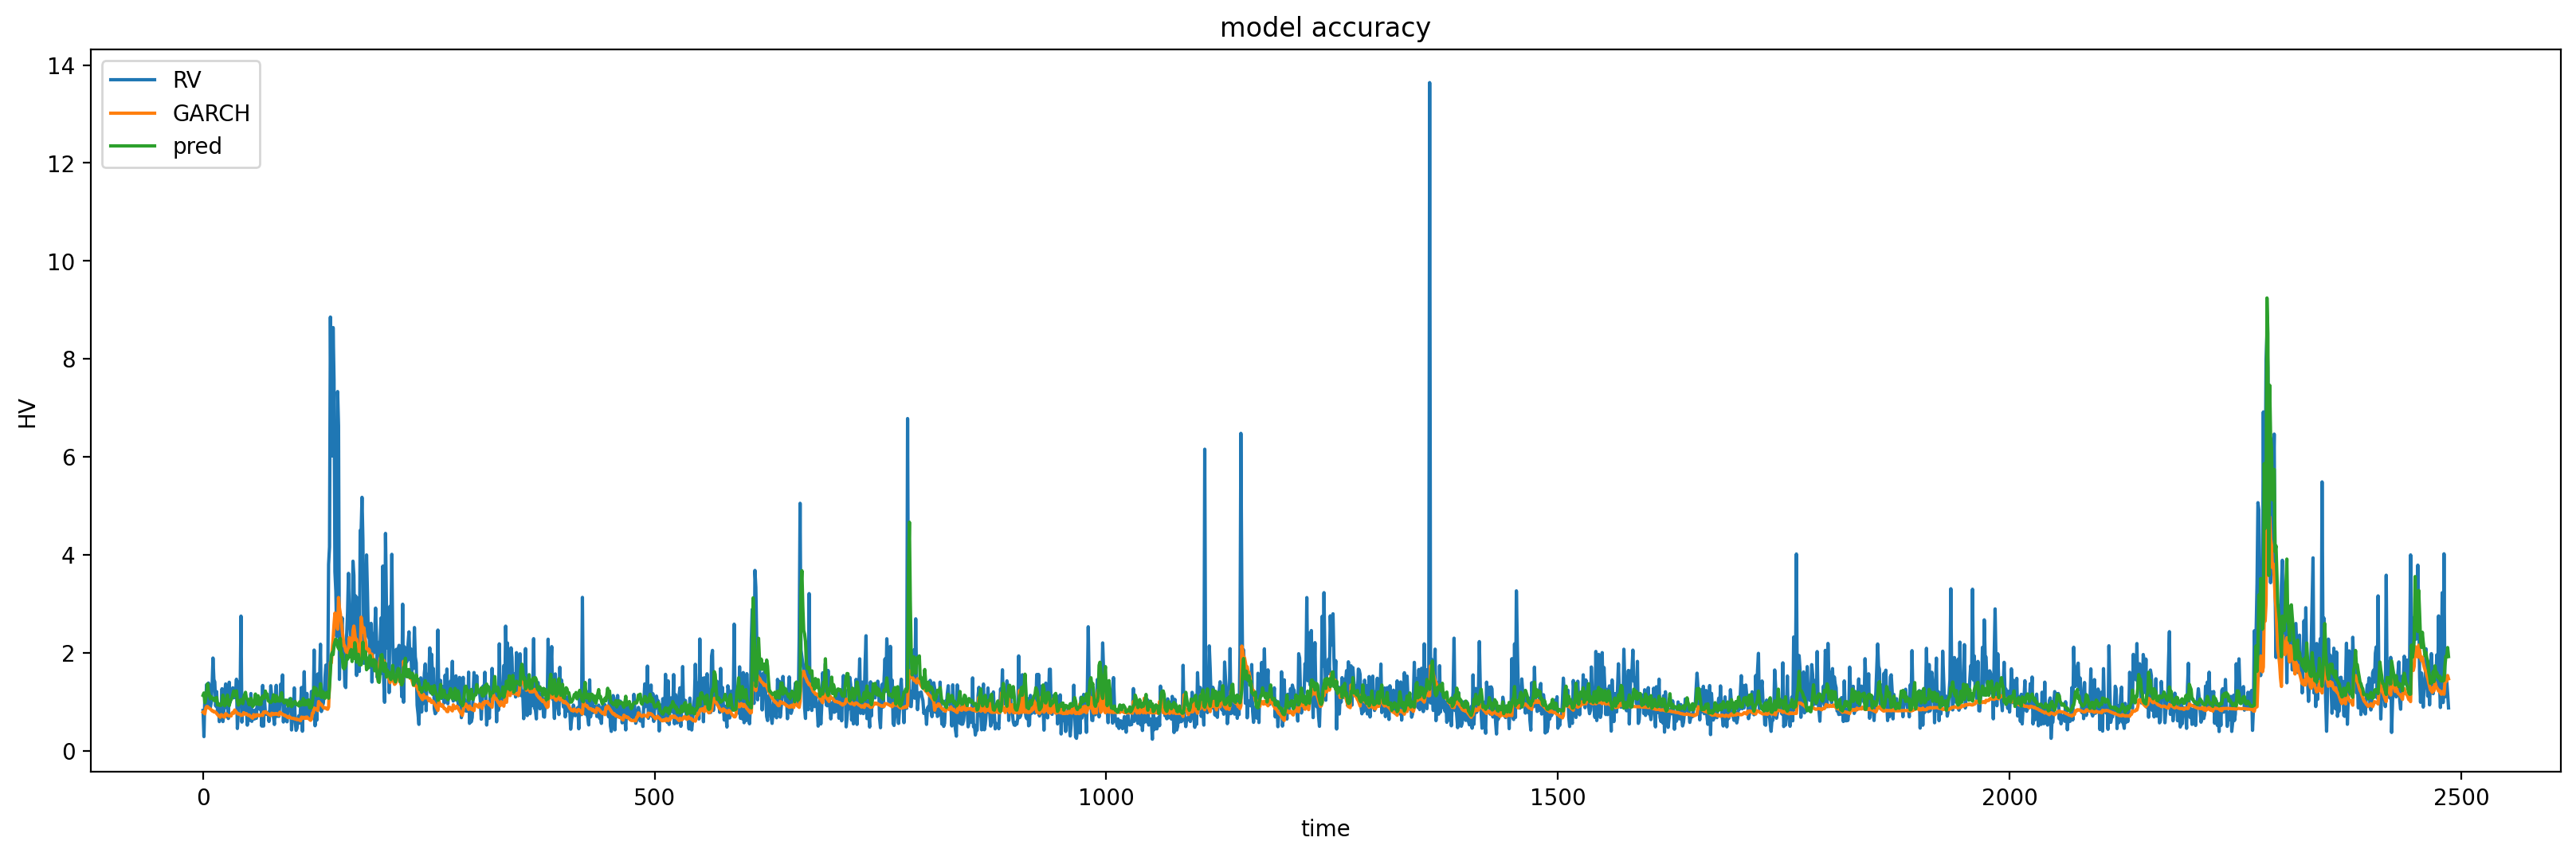

In [29]:
figs = plt.figure()
plt.figure(figsize=(20, 6), dpi=200)
plt.plot(garch_forecasts[['vGKYZ_252']][-len(yhat_total):].reset_index(drop=True))
plt.plot(garch_forecasts[['sGARCH_norm_sigma']][-len(yhat_total):].reset_index(drop=True))
#plt.plot(garch_forecasts[['garch_forecasts[, c("Realized")]']][-len(yhat_total):].reset_index(drop=True)**2)
plt.plot(yhat_total)
#plt.plot(garch_forecasts[['Mu']][-568:].reset_index(drop=True))
#plt.plot(Xtest)
plt.title('model accuracy')
plt.ylabel('HV')
plt.xlabel('time')
plt.legend(['RV', 'GARCH','pred'], loc='upper left')

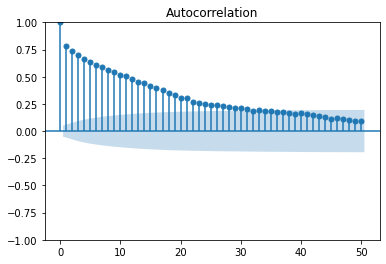

In [18]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(garch_forecasts[['vGKYZ']][-len(yhat_total):], lags=50)
plt.show()

C:\Users\et\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


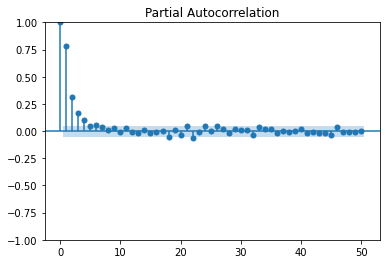

In [19]:
sm.graphics.tsa.plot_pacf(garch_forecasts[['vGKYZ']][-len(yhat_total):], lags=50)
plt.show()

In [58]:
#save data
#sigma_df = pd.DataFrame(garch_forecasts[['SvOLHC']][-len(yhat_total):])
#sigma_df.reset_index(drop=True, inplace=True)

#sigma_df = feather.read_dataframe('../EXPORTS/lstm_sigma_dt_wig.feather')

sigma_df['LSTM-gjrGARCH-SSTD'] = pd.DataFrame(yhat_total)
sigma_df

,vGKYZ_252,LSTM-GARCH-NORM,LSTM-GARCH-STD,LSTM-GARCH-SSTD,LSTM-eGARCH-NORM,LSTM-eGARCH-STD,LSTM-eGARCH-SSTD,LSTM-gjrGARCH-NORM,LSTM-gjrGARCH-STD,LSTM-gjrGARCH-SSTD,LSTM-apARCH-NORM,LSTM-apARCH-STD,LSTM-apARCH-SSTD
0,0.822040,1.116546,1.112321,1.153708,1.272741,1.261328,1.234378,1.022188,1.055144,1.044223,1.158026,1.191957,1.195614
1,0.286576,1.166501,1.189732,1.198968,1.318925,1.321985,1.251420,1.105173,1.068887,1.021178,1.123912,1.255615,1.267283
2,1.128581,0.989160,0.894217,1.032476,1.087657,1.070639,1.056627,0.898955,0.888742,0.894372,0.959413,1.013612,0.987747
3,1.041670,1.056352,1.010346,1.098263,1.207201,1.156955,1.145638,1.066582,1.124239,1.118549,1.032118,1.114016,1.098212
4,1.349908,1.157590,1.184428,1.197352,1.324970,1.289313,1.272571,1.095756,1.194832,1.199683,1.100814,1.241244,1.250393
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,1.097320,1.763735,1.806002,1.824017,1.420350,1.534771,1.510047,1.516997,1.515219,1.517580,1.546915,1.576161,1.559779
2483,1.261118,1.913347,1.979476,1.964864,1.687941,1.801700,1.776032,1.740624,1.762128,1.791943,1.845744,1.804496,1.755816
2484,1.438284,1.875504,2.013145,1.911220,1.810086,1.868806,1.839287,1.811199,1.858577,1.886055,1.921551,1.885220,1.788072
2485,1.169053,2.095555,2.183668,2.150169,2.009682,2.133507,2.101488,2.079385,2.139467,2.129587,2.072832,2.150131,2.085028


In [59]:
feather.write_dataframe(sigma_df, '../EXPORTS/lstm_sigma_dt_wig.feather')

In [92]:
#kerastuner

import keras_tuner as kt

def build_model(hp):

    kernels = hp.Choice('l2', values=[0.00009,0.00004,0.00002,0.00012])
    #units = hp.Int(name = 'units1', min_value = 16, max_value = 128, step = 16)
    units1 = hp.Choice('units1', [64, 128, 256, 512])
    units2 = hp.Choice('units2', [64, 128, 256, 512])
    units3 = hp.Choice('units3', [64, 128, 256, 512])
    lr = hp.Choice('lr', [0.01, 0.005, 0.0009, 0.00015])
    drop = hp.Choice('drop', [0.1, 0.4, 0.01, 0.0002, 0.05])
    act = hp.Choice(name = 'act', values = ['tanh', 'relu', 'elu'])

    model = Sequential()

    model.add(LSTM(units1, activation=act, kernel_regularizer=regularizers.l2(kernels), return_sequences=True, input_shape=(n_steps, n_features) ))
    model.add(Dropout(drop))

    model.add(LSTM(units2, activation=act, kernel_regularizer=regularizers.l2(kernels), return_sequences=True))
    model.add(Dropout(drop))

    model.add(LSTM(units3, kernel_regularizer=regularizers.l2(kernels), activation=act))
    model.add(Dropout(drop))


    model.add(Dense(1))#activation linear jest chyba domyślnie

    opt = tf.keras.optimizers.Adam(learning_rate = lr)
    model.compile(optimizer=opt, loss = "mse", metrics="mae")

    return model

In [93]:
tunerhp2 = kt.Hyperband(build_model,
                     objective='loss',
                     max_epochs=150,
                     factor=3,
                     directory='C:/kt',
                     project_name='tunerhp21')

In [94]:
tunerhp2.search(X, y,
             validation_split = 0.3333,
             batch_size = 3000,
             epochs=150)

Trial 254 Complete [00h 02m 13s]
loss: 0.44303637742996216

Best loss So Far: 0.40778180956840515
Total elapsed time: 00h 47m 39s
INFO:tensorflow:Oracle triggered exit


In [95]:
models = tunerhp2.get_best_models(num_models=2)
tunerhp2.results_summary()

Results summary
Results in C:/kt\tunerhp21
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
l2: 9e-05
units1: 128
units2: 512
units3: 512
lr: 0.005
drop: 0.01
act: elu
tuner/epochs: 150
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.40778180956840515
Trial summary
Hyperparameters:
l2: 9e-05
units1: 256
units2: 256
units3: 64
lr: 0.01
drop: 0.01
act: relu
tuner/epochs: 150
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.4156584143638611
Trial summary
Hyperparameters:
l2: 2e-05
units1: 128
units2: 512
units3: 128
lr: 0.005
drop: 0.0002
act: tanh
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: af31c3683a42708db846a006dd162709
Score: 0.4238719642162323
Trial summary
Hyperparameters:
l2: 2e-05
units1: 64
units2: 512
units3: 512
lr: 0.005
drop: 0.05
act: tanh
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: d81370dd267356c480248949de

In [ ]:
models[0]